In [1]:
import pandas as pd
import numpy as np
import statistics
import sklearn.metrics
import warnings
import random as rn
warnings.filterwarnings("ignore")

In [2]:
# set the seed for reproducibility
sd = 1234
np.random.seed(sd)
rn.seed(sd)
%env PYTHONHASHSEED=0


env: PYTHONHASHSEED=0


In [3]:
def get_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    num_correct_ann= annotation_df[annotation_df[correct_id_col]==annotation_df[predicted_id_col]].shape[0]
    acc=num_correct_ann/annotation_df.shape[0]
    return acc

In [4]:
def get_balanced_accuracy_verbose(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        print(cell_type)
        num_cells =cell_type_sub.shape[0]
        print("predicted cell ID")
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        print(perc)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    print("balanced accuracy:")
    print(balanced_accuracy)
    return balanced_accuracy

In [5]:
def get_balanced_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        num_cells =cell_type_sub.shape[0]
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    return balanced_accuracy

In [6]:
def get_cluster_accuracy(annotation_df, cluster_id_column ='clust',correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    correc_ann_counter=0
    annotation_df = annotation_df.groupby(cluster_id_column).filter(lambda x: len(x) > 10)
    cluster_ids =sorted(set(annotation_df[cluster_id_column]))
    for cluster_id in cluster_ids:
        cluster_sub = annotation_df[annotation_df[cluster_id_column]==cluster_id]   
        clust_real_id_counts = cluster_sub[correct_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_real_id = clust_real_id_counts.iloc[np.lexsort((clust_real_id_counts.index, -clust_real_id_counts.values))].index[0]
        clust_predicted_id_counts = cluster_sub[predicted_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_predicted_id = clust_predicted_id_counts.iloc[np.lexsort((clust_predicted_id_counts.index, -clust_predicted_id_counts.values))].index[0]
        if clust_real_id == clust_predicted_id:
            correc_ann_counter += 1
        else:
            continue
    clust_accuracy= correc_ann_counter/len(cluster_ids)
    return clust_accuracy

In [7]:
def get_cohens_kappa_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    cohens_kappa_score= sklearn.metrics.cohen_kappa_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(cohens_kappa_score)

In [8]:
def get_F1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest 
        # then convert df labels to binary classification tasks
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        #cell_type_sub = cell_type_sub[[correct_id_col, predicted_id_col]]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        F1_cell_type = sklearn.metrics.f1_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        F1_list.append(F1_cell_type)
    return(F1_list)

In [9]:
def get_macroF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID', label_list=None):
    if label_list ==None:
        label_list  = annotation_df[correct_id_col].value_counts().index   
    macroF1_score = sklearn.metrics.f1_score(annotation_df[correct_id_col], annotation_df[predicted_id_col],average='macro', labels=label_list)
    return(macroF1_score)


In [10]:
def get_medianF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_scores = get_F1_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianF1_score = statistics.median(F1_scores)
    return(medianF1_score)

In [11]:
def get_precision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        precision_cell_type = sklearn.metrics.precision_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        precision_list.append(precision_cell_type)
    return(precision_list)

In [12]:
def get_medianPrecision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_scores = get_precision_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(precision_scores)
    return(medianPrecision_score)

In [13]:
def get_recall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        recall_cell_type = sklearn.metrics.recall_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        recall_list.append(recall_cell_type)
    return(recall_list)

In [14]:
def get_medianRecall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_scores = get_recall_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(recall_scores)
    return(medianPrecision_score)

In [15]:
def get_adjusted_rand_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    adjusted_rand_score= sklearn.metrics.adjusted_rand_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(adjusted_rand_score)

In [16]:
def get_mathews_corr_coef_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    matthews_corrcoef_score= sklearn.metrics.matthews_corrcoef(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(matthews_corrcoef_score)

In [17]:
def get_common_cells(*dataframes):
    df_cell_list = [v.index for v in dataframes]
    common_cells= list(set.intersection(*map(set,df_cell_list)))
    return(common_cells)

In [18]:
def get_combined_annotations_df_for_common_cells(*frames, common_cells, cell_ID_column = "cell_IDs"):
    if not frames:
        return None
    if len(frames) == 1:
        return frames[0]
    out = frames[0]
    out = out.loc[common_cells,]
    for df in frames[1:]:
        out = out.merge(df.loc[common_cells,], on=cell_ID_column)
    return out

In [19]:

common_cells_across_methods = pd.read_csv("../../../../results/Fig5_SFig3-NeurIPS_BM_scmultiome/compare_annotation_performances/commonCells.csv", index_col=False)

In [20]:
common_cells_across_methods

,0
0,TTGGATTCACCTAATG-1
1,CCTAAATCATGGTTAT-1
2,GTGAGGAGTTCCGGCT-1
3,CATAGACTCAGGTTTA-1
4,GGTTTCCTCCAAACAC-1
...,...
5761,TCCGGAATCTTGACCC-1
5762,CCTGTTGGTGTCCAAA-1
5763,ATATGGTGTGCAACTA-1
5764,GTCAAACTCTTAATGG-1


In [21]:
NeurIPS_BM_s1d1_metadata = pd.read_csv("../../../../../scATAcat_notebooks_for_paper/jan2024/data/NeurIPS_BM_scmultiome/03_cell_IDs/NeurIPS_BM_s1d1_metadata.csv", index_col=0)

In [22]:
NeurIPS_BM_s1d1_metadata["cellIDs"] = NeurIPS_BM_s1d1_metadata.index.str.split("-").str[:-1].str.join('-')

In [23]:
NeurIPS_BM_s1d1_metadata[["cellIDs", "cell_type"]]

,cellIDs,cell_type
TAGTTGTCACCCTCAC-1-s1d1,TAGTTGTCACCCTCAC-1,Naive CD20+ B
CTATGGCCATAACGGG-1-s1d1,CTATGGCCATAACGGG-1,CD14+ Mono
CCGCACACAGGTTAAA-1-s1d1,CCGCACACAGGTTAAA-1,CD8+ T
TCATTTGGTAATGGAA-1-s1d1,TCATTTGGTAATGGAA-1,CD8+ T
ACCACATAGGTGTCCA-1-s1d1,ACCACATAGGTGTCCA-1,CD16+ Mono
...,...,...
AGACCCGGTTATCCTA-1-s1d1,AGACCCGGTTATCCTA-1,CD4+ T activated
GACCTAAGTGCCTCAC-1-s1d1,GACCTAAGTGCCTCAC-1,pDC
AGCTCATAGCTATATG-1-s1d1,AGCTCATAGCTATATG-1,CD4+ T activated
TACGTACAGGAAACTG-1-s1d1,TACGTACAGGAAACTG-1,CD4+ T naive


In [24]:
NeurIPS_BM_s1d1_metadata.index = NeurIPS_BM_s1d1_metadata.cellIDs

In [25]:
NeurIPS_BM_s1d1_metadata = NeurIPS_BM_s1d1_metadata[["cellIDs", "cell_type"]]

In [26]:
NeurIPS_ann_rename_dict = {'B1 B': 'Bcell',
 'CD14+ Mono': 'Mono',
 'CD16+ Mono': 'Mono',
 'CD4+ T activated':"CD4Tcell",
 'CD4+ T naive':"CD4Tcell",
 'CD8+ T':"CD8Tcell",
 'Erythroblast':"Ery",
 'G/M prog':"GMP",
 'HSC':"HSC",
 'ID2-hi myeloid prog':"CMP",
 'ILC':"ILC",
 'Lymph prog':"CLP",
 'MK/E prog':"MEP",
 'NK':"NKcell",
 'Naive CD20+ B':"Bcell",
 'Normoblast':"Ery", 
 'Plasma cell':"Plasma cell",
 'Proerythroblast':"Ery",
 'Transitional B':"Bcell",
 'cDC2':"cDC2",
 'pDC':'pDC'}

In [27]:
NeurIPS_BM_s1d1_metadata['NeurIPS_ann_simp'] =list(NeurIPS_BM_s1d1_metadata["cell_type"].map(NeurIPS_ann_rename_dict))
NeurIPS_BM_s1d1_metadata.index.name = None
NeurIPS_BM_s1d1_metadata.columns=["cell_IDs", "ground_truth_annotations","ground_truth_annotations_simplified" ]
NeurIPS_BM_s1d1_metadata

,cell_IDs,ground_truth_annotations,ground_truth_annotations_simplified
TAGTTGTCACCCTCAC-1,TAGTTGTCACCCTCAC-1,Naive CD20+ B,Bcell
CTATGGCCATAACGGG-1,CTATGGCCATAACGGG-1,CD14+ Mono,Mono
CCGCACACAGGTTAAA-1,CCGCACACAGGTTAAA-1,CD8+ T,CD8Tcell
TCATTTGGTAATGGAA-1,TCATTTGGTAATGGAA-1,CD8+ T,CD8Tcell
ACCACATAGGTGTCCA-1,ACCACATAGGTGTCCA-1,CD16+ Mono,Mono
...,...,...,...
AGACCCGGTTATCCTA-1,AGACCCGGTTATCCTA-1,CD4+ T activated,CD4Tcell
GACCTAAGTGCCTCAC-1,GACCTAAGTGCCTCAC-1,pDC,pDC
AGCTCATAGCTATATG-1,AGCTCATAGCTATATG-1,CD4+ T activated,CD4Tcell
TACGTACAGGAAACTG-1,TACGTACAGGAAACTG-1,CD4+ T naive,CD4Tcell


In [28]:
leiden_resolutions = ['0.1' ,'0.2' ,'0.3' ,'0.4' ,'0.5' ,'0.6' ,'0.7' ,'0.8' ,'0.9' ,'1.0' ,'1.1' ,'1.2' ,'1.3' ,'1.4' ,'1.5' ,'1.6' ,'1.7','1.8' ,'1.9' ,'2.0', '2.1', '2.2', '2.3', '2.4', '2.5']

In [29]:
# prepare results dataframe

scores_df = pd.DataFrame( index=['leiden_'+i for i in leiden_resolutions])

In [30]:
for res in leiden_resolutions:
    result_path = "../../../../results/Supplementary_tables/analysis_on_clustering_parameter/NeurIPS_BM_scmultiome_performance_acros_clustering_res/res"+ res + "/outputs/scATAcat_annotations_leiden_" + res +".csv"
    scATAcat_annotations = pd.read_csv(result_path, index_col=0)
    scATAcat_annotations.index.name = None
    scATAcat_annotations.columns = ['leiden_'+ res, 'scATAcat_annotation','cell_IDs']
    #scATAcat_annotations.columns = ['leiden_'+res, 'scATAcat_annotation' ,'ground_truth_annotations']
    scATAcat_annotations['cell_IDs'] = scATAcat_annotations.index
    cluster_id_column ='leiden_'+res
    scATAcat_annotations.index.name = None
    common_cells = list(common_cells_across_methods['0'])
    all_methods_for_commonCells= get_combined_annotations_df_for_common_cells(scATAcat_annotations,NeurIPS_BM_s1d1_metadata, common_cells=common_cells, cell_ID_column = "cell_IDs")
    common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified))

    all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
    annotation_df = all_methods_for_commonCells_commonAnnotations
    correct_id_col = 'ground_truth_annotations_simplified'
    predicted_id_col = "scATAcat_annotation"
    scores_df.loc['leiden_'+ res, "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
    scores_df.loc['leiden_'+ res, "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    scores_df.loc['leiden_'+ res, 'num_clust'] = scATAcat_annotations['leiden_'+ res].max()+1


In [31]:
all_methods_for_commonCells_commonAnnotations

,leiden_2.5,scATAcat_annotation,cell_IDs,ground_truth_annotations,ground_truth_annotations_simplified
0,3,Bcell,TTGGATTCACCTAATG-1,Naive CD20+ B,Bcell
1,10,Ery,CCTAAATCATGGTTAT-1,Erythroblast,Ery
3,9,CD4Tcell,CATAGACTCAGGTTTA-1,CD4+ T activated,CD4Tcell
4,0,Mono,GGTTTCCTCCAAACAC-1,CD14+ Mono,Mono
5,5,Mono,GGATTGCGTACCGTTT-1,CD14+ Mono,Mono
...,...,...,...,...,...
5761,0,Mono,TCCGGAATCTTGACCC-1,CD14+ Mono,Mono
5762,11,CD8Tcell,CCTGTTGGTGTCCAAA-1,CD4+ T activated,CD4Tcell
5763,9,CD4Tcell,ATATGGTGTGCAACTA-1,CD4+ T activated,CD4Tcell
5764,2,CD4Tcell,GTCAAACTCTTAATGG-1,CD4+ T naive,CD4Tcell


In [32]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score,num_clust
leiden_0.1,0.976507,0.969628,1.000000,0.971126,0.986466,0.991498,0.992647,0.970552,0.954399,0.970180,5.0
leiden_0.2,0.938833,0.921626,0.857143,0.888023,0.927427,0.989396,0.933962,0.926907,0.901341,0.925839,7.0
leiden_0.3,0.940890,0.924080,0.857143,0.889443,0.928437,0.989396,0.933962,0.929336,0.907821,0.928380,7.0
leiden_0.4,0.936962,0.920900,0.857143,0.882546,0.926415,0.987302,0.924528,0.924707,0.904166,0.923757,7.0
leiden_0.5,0.936962,0.923336,0.875000,0.883394,0.926415,0.989384,0.943396,0.924735,0.903806,0.923767,8.0
leiden_0.6,0.960531,0.947884,1.000000,0.937854,0.959732,0.989362,0.972054,0.952274,0.924934,0.952113,10.0
leiden_0.7,0.962402,0.956441,1.000000,0.937103,0.963216,0.989373,0.962264,0.954651,0.929679,0.954459,10.0
leiden_0.8,0.956229,0.943355,1.000000,0.924518,0.952837,0.987823,0.974468,0.947190,0.917432,0.946897,10.0
leiden_0.9,0.955474,0.924646,1.000000,0.910422,0.946330,0.987808,0.960739,0.946747,0.924652,0.946446,12.0
leiden_1.0,0.937259,0.921837,1.000000,0.901224,0.922709,0.986792,0.949498,0.926699,0.877406,0.924858,13.0


In [33]:
scores_df.to_csv('../../../../results/Supplementary_tables/analysis_on_clustering_parameter/NeurIPS_BM_scmultiome_performance_acros_clustering_res/NeurIPS_BM_scmultiome_performance_acros_clustering_res.csv')

In [35]:
figures_dir = "../../../../results/Supplementary_tables/analysis_on_clustering_parameter/Morabito2021_brainCortex_snATAC_performance_acros_clustering_res/figures/"

In [36]:
import os
os.makedirs(figures_dir,exist_ok=True)

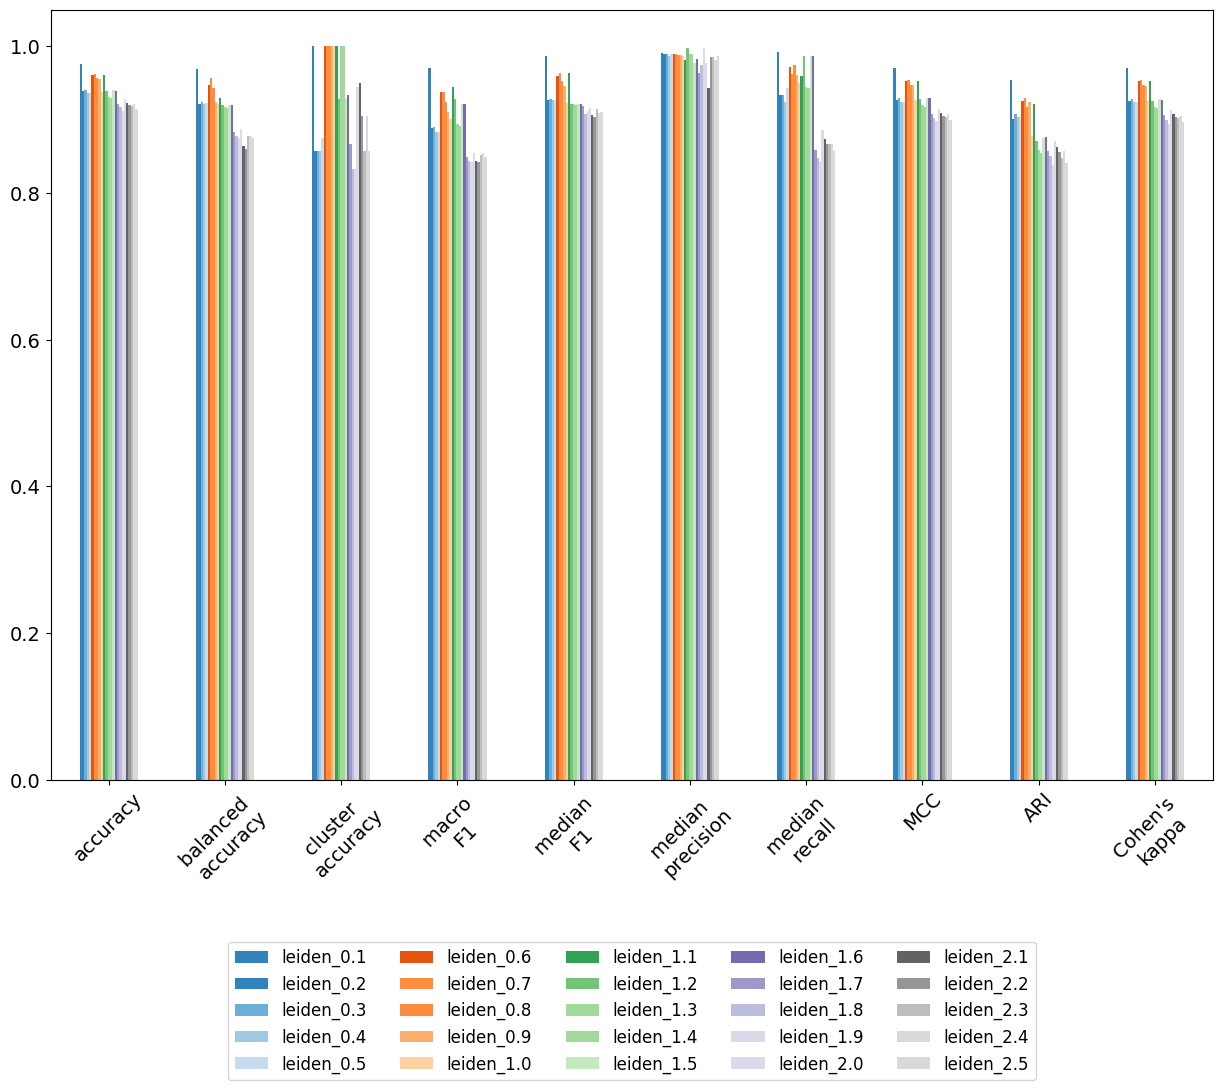

In [37]:
import matplotlib.pyplot as plt
scores_df = scores_df.iloc[:,:-1]
scores_df.columns = ['accuracy', 'balanced \naccuracy','cluster \naccuracy', 'macro \nF1', 'median \nF1',
                      'median \nprecision', 'median \nrecall','MCC', 'ARI', "Cohen's \nkappa"]

ax = scores_df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12,colormap='tab20c')
#ax.set_xlabel("evaluation metrics", fontsize=12)
ax.set_ylim(ymin=0.0)
ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=12)
#plt.title("evaluation scores for common cells and common annotations without EpiAnno", fontsize=15)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.show()
plt.savefig(figures_dir + "Morabito2021_brainCortex_snATAC_performance_acros_clustering_res.png", bbox_inches='tight', transparent=True)
